In [1]:
import sys
import os
# Get the absolute path to the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
# Add it to sys.path
sys.path.append(project_root)

In [2]:
from bimpcc.dataset import get_blur_dataset
from bimpcc.dataset import get_dataset
import numpy as np
import scipy.sparse as sp
from bimpcc.models.recons_regularized import TVReconsRegularized
from bimpcc.models.tvreconstruction_model import TVReconstructionMPCC
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr

In [3]:
def plot_experiment(true,noisy,u, alpha):
    
    fig,ax = plt.subplots(1,3,figsize=(14,4))
    ax[0].imshow(true,cmap='gray')
    ax[0].set_title('True Image')
    ax[0].axis('off')
    ax[1].imshow(noisy,cmap='gray')
    ax[1].set_title('Noisy Image\nPSNR: {:.4f}'.format(psnr(true,noisy)))
    ax[1].axis('off')
    ax[2].imshow(u,cmap='gray')
    ax[2].set_title(f'Reconstructed Image\nPSNR: {psnr(true,u):.4f}\n alpha = {alpha}')
    # ax[2].set_xlabel('alpha = {}'.format(alpha))
    ax[2].axis('off')

    plt.show()

In [4]:
scale = 10

In [5]:
dataset = get_blur_dataset("cameraman",scale=scale)
# dataset = get_dataset("cameraman",scale=scale)
true, blurred = dataset.get_training_data()

(np.float64(-0.5), np.float64(9.5), np.float64(9.5), np.float64(-0.5))

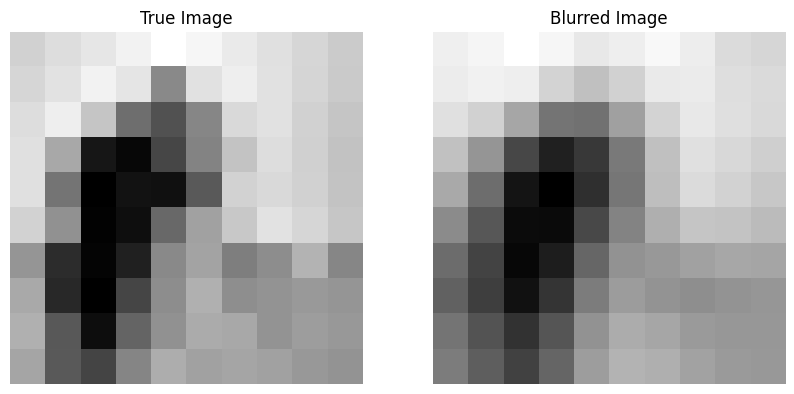

In [6]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(true,cmap='gray')
ax[0].set_title('True Image')
ax[0].axis('off')
ax[1].imshow(blurred,cmap='gray')
ax[1].set_title('Blurred Image')
ax[1].axis('off')

In [7]:
from bimpcc.utils import gaussian_blur_sparse_matrix_symmetric
forward_map = gaussian_blur_sparse_matrix_symmetric(true.shape)
# forward_map = sp.eye(np.prod(true.shape))
model = TVReconsRegularized(forward_map, true, blurred, epsilon=1e-3)

In [8]:
res,x_opt,fun_opt = model.solve(max_iter=3000,tol=1e-4,print_level=5)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     3340
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      281
                     variables with only lower bounds:      101
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      280
Total number of inequality c

In [9]:
u, q, alpha = model.objective_func.parse_vars(x_opt)

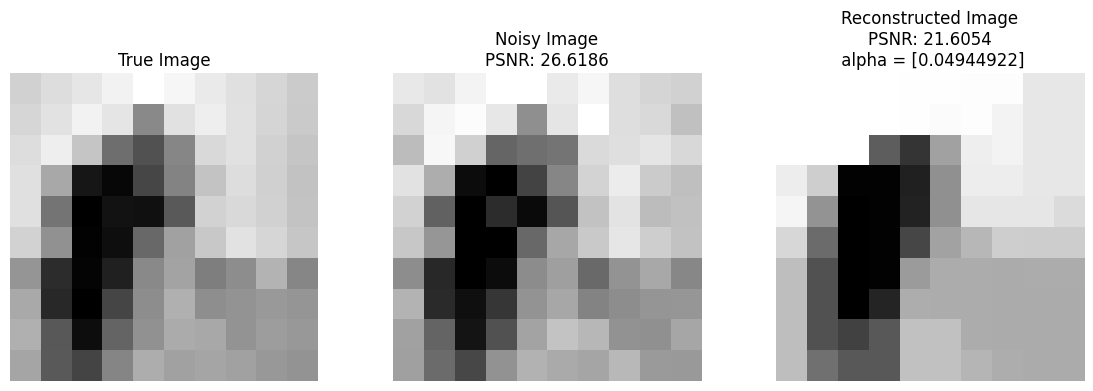

In [10]:
u = u.reshape((scale,scale))
plot_experiment(true,blurred,u,alpha)

In [11]:
m = q.flatten().size
n = m // 2
Ku = model.K @ u.flatten()
V = Ku.reshape(2, -1).T
normKu = np.apply_along_axis(np.linalg.norm, axis=1, arr=V)
Q = q.reshape(2,-1).T
normQ = np.apply_along_axis(np.linalg.norm, axis=1, arr=Q)
r0 = normKu
delta0 = normQ

In [12]:
Kxu = Ku[:n]  # Primeras n componentes
Kyu = Ku[n:]  # Últimas n componentes
qx = q[:n]  # Primeras n componentes
qy = q[n:]  # Últimas n componentes
epsilon = 1e-10  

# Condiciones para calcular theta según los casos dados
theta0 = np.zeros(n)  # Inicializamos theta0

# Caso 1: r_i ≠ 0
mask_r_nonzero = r0 > epsilon
theta0[mask_r_nonzero] = np.arccos(Kxu[mask_r_nonzero] / r0[mask_r_nonzero])
theta0[mask_r_nonzero & (Kyu < 0)] *= -1  # Si Ky^i u < 0, negamos theta0

# Caso 2: r_i = 0 y delta_i ≠ 0
mask_r_zero_delta_nonzero = (r0 <= epsilon) & (delta0 > epsilon)
theta0[mask_r_zero_delta_nonzero] = np.arccos(qx[mask_r_zero_delta_nonzero] / delta0[mask_r_zero_delta_nonzero])
theta0[mask_r_zero_delta_nonzero & (qy < 0)] *= -1  # Si qy^i < 0, negamos theta0

# Caso 3: r_i = 0 y delta_i = 0 (theta0 indefinido)
mask_r_zero_delta_zero = (r0 <= epsilon) & (delta0 <= epsilon)
theta0[mask_r_zero_delta_zero] = 0

In [13]:
x0_mpcc = np.concatenate((u.flatten(),q.flatten(),r0,delta0,theta0,alpha))

In [8]:
mpcc_model = TVReconstructionMPCC(forward_map, true, blurred, x0=None, epsilon=1e-3)

In [10]:
res_mpcc,x_opt_mpcc,fun_opt_mpcc = mpcc_model.solve(max_iter=100,tol=1e-4,print_level=0,verbose=True)

Iter   Termination_status            Objective      MPCC_compl               t

0                 0  0.3644094131397604      2.5417259800437053                 1.0

1                -3  0.36792373783953136     2.2338905201749024                 0.5

2                 0  0.3673733839561898      2.2072737014938317                0.55

3                -3  0.3773792682094266      1.5631173702682362      0.24750000000000003

4                -3  0.37552870858091547     1.6620644322330318      0.27225000000000005

5                -3  0.3737944583160891      1.7805065845670993      0.2994750000000001

6                 0  0.37210411074815414     1.887579365524741       0.3294225000000001

7                 0  0.3901580141062698      0.7234871754046943      0.10806705112500006

8                 0  0.40506471910467323     0.27357184466249224     0.035451396121556275

9                 0  0.4272846712128437      0.11375035162874503     0.011629830497676538

10                 0  0.44391004977211124     0.04242307443059313     0.003815165894762789

11                 0  0.4490034194764709      0.01787463941247754     0.0012515651717769332

12                 0  0.4553332898198729      0.007804866728085936    0.000410575954601423

13                 0  0.4600639795262567      0.0031653291034719083   0.00013468944190699685

14                 0  0.47088693070515        0.003435859720765578    4.4184871417590325e-05

15                 0  0.4889962754412885      0.005053339170923973    1.449484706854051e-05

Intermediate result:  message: b'Algorithm terminated successfully at a locally optimal point, satisfying the 
convergence tolerances (can be specified by options).'
 success: True
  status: 0
     fun: 0.4889962754412885
       x: [ 8.957e-01  9.212e-01 ... -3.905e+00  3.492e-03]
     nit: 580
    info:     status: 0
                   x: [ 8.957e-01  9.212e-01 ... -3.905e+00  3.492e-03]
                   g: [ 5.673e-04 -9.810e-09 ... -9.758e-19 -2.602e-18]
             obj_val: 0.4889962754412885
              mult_g: [-1.617e-08 -5.255e-02 ...  2.440e-01  1.247e-01]
            mult_x_L: [ 1.116e-11  1.086e-11 ...  0.000e+00  2.864e-09]
            mult_x_U: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
          status_msg: b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence 
tolerances (can be specified by options).'
    nfev: 583
    njev: 582

Intermediate fn: 0.4889962754412885

complementarity: 0.005053339170923973

* (STOPPED) Iteration 17: Solving the NLP problem for t = 1e-05 with complementarity: 0.005053339170923973

In [11]:
u_mpcc, q_mpcc, r_mpcc, delta_mpcc, theta_mpcc, alpha_mpcc = mpcc_model.objective_func.parse_vars(x_opt_mpcc)

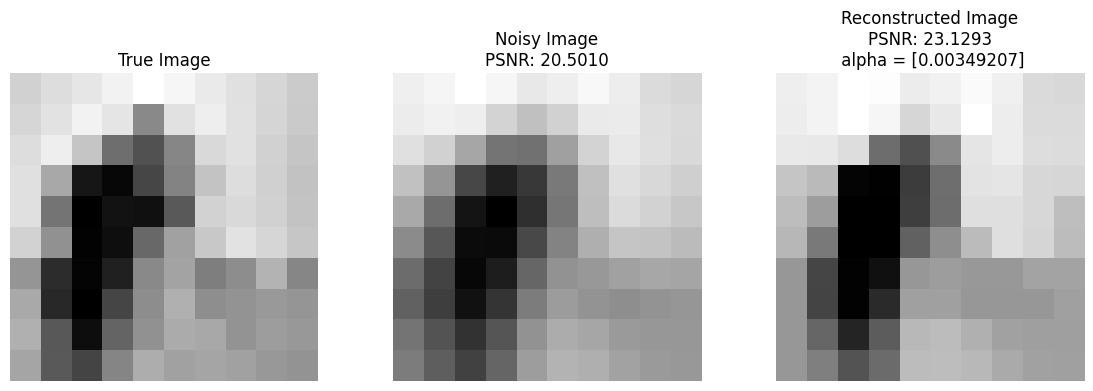

In [12]:
u_mpcc = u_mpcc.reshape((scale,scale))
plot_experiment(true,blurred,u_mpcc,alpha_mpcc)